# Image Classification: L1 vs L2 Distance Comparison

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import pandas as pd

## 1. Data Loading and Preprocessing

In [ ]:
def load_dataset(root_dir):
    classes = ['cat', 'dog', 'panda']
    X = []
    y = []

    print("Loading dataset...")

    for label_idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Manual file listing instead of glob
        files = os.listdir(class_dir)

        for file_name in files:
            file_path = os.path.join(class_dir, file_name)
            try:
                if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                with Image.open(file_path) as img:
                    # Convert to grayscale and resize
                    img_processed = img.convert('L').resize((32, 32))
                    # Flatten to 1D array
                    img_vector = np.array(img_processed).flatten()

                    X.append(img_vector)
                    y.append(label_idx)
            except Exception as e:
                print(f"Skipping {file_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    # Shuffle the dataset manually
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices], classes

# Check if dataset exists before loading
if os.path.exists('animal_dataset'):
    X_data, y_data, class_names = load_dataset('animal_dataset')
    print(f"Dataset loaded. X shape: {X_data.shape}, y shape: {y_data.shape}")
else:
    print("Dataset 'animal_dataset' not found. Please ensure it is extracted.")

Loading dataset...


Dataset loaded. X shape: (300, 1024), y shape: (300,)


## 2. k-Nearest Neighbors (k-NN) Implementation

In [ ]:
class KNN:
    def __init__(self, k=3, metric='l2'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        y_pred = []
        # Iterate over each test sample
        for x in X_test:
            # Calculate distances to all training samples
            if self.metric == 'l1':
                # Manhattan Distance: sum(|x_train - x_test|)
                distances = np.sum(np.abs(self.X_train - x), axis=1)
            elif self.metric == 'l2':
                # Euclidean Distance: sqrt(sum((x_train - x_test)^2))
                distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            else:
                raise ValueError("Invalid metric. Use 'l1' or 'l2'.")

            # Get indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]

            # Get the labels of the k nearest neighbors
            k_nearest_labels = self.y_train[k_indices]

            # Majority vote
            counts = np.bincount(k_nearest_labels, minlength=3)
            predicted_label = np.argmax(counts)
            y_pred.append(predicted_label)

        return np.array(y_pred)

## 3. 5-Fold Cross-Validation

In [ ]:
def run_cross_validation(X, y, k_candidates):
    # Manual 5-Fold Cross-Validation
    num_samples = len(X)
    fold_size = num_samples // 5
    indices = np.arange(num_samples)
    # Shuffle indices for CV
    np.random.seed(101) # Set seed for reproducibility
    np.random.shuffle(indices)

    l1_scores = {k: [] for k in k_candidates}
    l2_scores = {k: [] for k in k_candidates}

    for fold_idx in range(5):
        start = fold_idx * fold_size
        end = (fold_idx + 1) * fold_size if fold_idx < 4 else num_samples

        val_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))

        X_train_fold, X_val_fold = X[train_indices], X[val_indices]
        y_train_fold, y_val_fold = y[train_indices], y[val_indices]

        print(f"Processing Fold {fold_idx + 1}...")

        for k in k_candidates:
            # L1 Evaluation
            model_l1 = KNN(k=k, metric='l1')
            model_l1.fit(X_train_fold, y_train_fold)
            preds_l1 = model_l1.predict(X_val_fold)
            acc_l1 = np.mean(preds_l1 == y_val_fold)
            l1_scores[k].append(acc_l1)

            # L2 Evaluation
            model_l2 = KNN(k=k, metric='l2')
            model_l2.fit(X_train_fold, y_train_fold)
            preds_l2 = model_l2.predict(X_val_fold)
            acc_l2 = np.mean(preds_l2 == y_val_fold)
            l2_scores[k].append(acc_l2)

    return l1_scores, l2_scores

k_list = [1, 3, 5, 7, 9, 11, 13, 15, 20, 30, 50]
l1_results, l2_results = run_cross_validation(X_data, y_data, k_list)

Processing Fold 1...


Processing Fold 2...


Processing Fold 3...


Processing Fold 4...


Processing Fold 5...


## 4. Results and Analysis

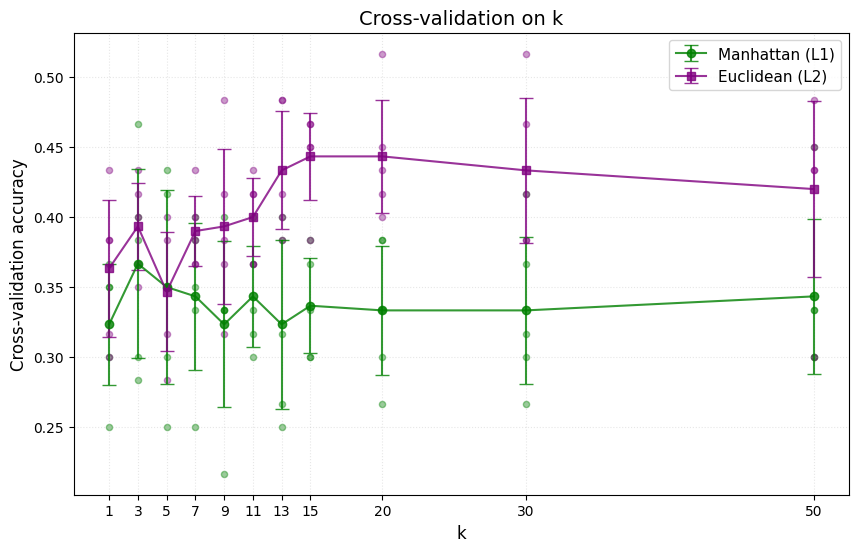

L1 Best K: 3 with Accuracy: 36.67%
L2 Best K: 15 with Accuracy: 44.33%


In [ ]:
plt.figure(figsize=(10, 6))

# Calculate stats for L1
l1_means = np.array([np.mean(l1_results[k]) for k in k_list])
l1_stds = np.array([np.std(l1_results[k]) for k in k_list])

# Calculate stats for L2
l2_means = np.array([np.mean(l2_results[k]) for k in k_list])
l2_stds = np.array([np.std(l2_results[k]) for k in k_list])

# Plot L1
plt.errorbar(k_list, l1_means, yerr=l1_stds, fmt='-o', label='Manhattan (L1)', color='green', capsize=5, alpha=0.8)
# Scatter for L1 folds
for i, k in enumerate(k_list):
    plt.scatter([k] * len(l1_results[k]), l1_results[k], color='green', alpha=0.4, s=20)

# Plot L2
plt.errorbar(k_list, l2_means, yerr=l2_stds, fmt='-s', label='Euclidean (L2)', color='purple', capsize=5, alpha=0.8)
# Scatter for L2 folds
for i, k in enumerate(k_list):
    plt.scatter([k] * len(l2_results[k]), l2_results[k], color='purple', alpha=0.4, s=20)

plt.title('Cross-validation on k', fontsize=14)
plt.xlabel('k', fontsize=12)
plt.ylabel('Cross-validation accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.3)
plt.xticks(k_list)
plt.show()

# Print statistics for Discussion
best_l1_k = k_list[np.argmax(l1_means)]
best_l1_acc = np.max(l1_means)
best_l2_k = k_list[np.argmax(l2_means)]
best_l2_acc = np.max(l2_means)

print(f"L1 Best K: {best_l1_k} with Accuracy: {best_l1_acc:.2%}")
print(f"L2 Best K: {best_l2_k} with Accuracy: {best_l2_acc:.2%}")

## 5. Discussion
Based on the 5-fold cross-validation results, **Euclidean distance (L2)** performed better than **Manhattan distance (L1)** for this grayscale dataset.

* **Best L2 accuracy:** **44.33%** at *k = 15*
* **Best L1 accuracy:** **36.67%** at *k = 3*

L2 produced more stable accuracy as *k* increased, likely because squaring pixel differences makes it more sensitive to large intensity mismatches, improving class separation.

However, both distance metrics are limited by the use of **raw grayscale pixel values**, which are highly sensitive to small shifts or rotations and lack color cues that could help distinguish classes. These limitations constrain the overall accuracy.

To enhance performance, more robust feature representations (e.g., **HOG**) or deep learning models (e.g., **CNNs**) could better capture spatial patterns and improve classification accuracy well beyond the current **44.33%** ceiling.


## 6. Top 5 Predictions

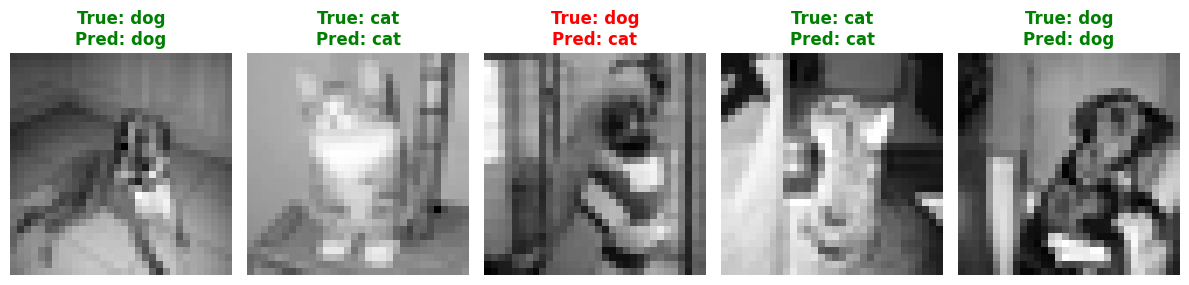

In [ ]:
# Train a final model on a split for demonstration
split_idx = int(0.8 * len(X_data))
X_train_demo, X_test_demo = X_data[:split_idx], X_data[split_idx:]
y_train_demo, y_test_demo = y_data[:split_idx], y_data[split_idx:]

demo_model = KNN(k=11, metric='l2')
demo_model.fit(X_train_demo, y_train_demo)

# Select 5 random indices
random_indices = np.random.choice(len(X_test_demo), 5, replace=False)
sample_images = X_test_demo[random_indices]
sample_labels = y_test_demo[random_indices]

predictions = demo_model.predict(sample_images)

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img_display = sample_images[i].reshape(32, 32)
    plt.imshow(img_display, cmap='gray')

    true_text = class_names[sample_labels[i]]
    pred_text = class_names[predictions[i]]

    col = 'green' if true_text == pred_text else 'red'
    plt.title(f"True: {true_text}\nPred: {pred_text}", color=col, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()